# Titanic: Machine Learning from Disaster

## 1. Look at the Big Picture

## 2. Get the Data

In [270]:
import os
import pandas as pd

TITANIC_PATH = "."

def load_titanic_data(titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "train.csv")
    return pd.read_csv(csv_path)

titanic = load_titanic_data()
titanic.set_index("PassengerId", inplace=True)
titanic.columns = [x.lower() for x in titanic.columns]

After loading the dataset and using the PassengerId column as our index, we split the data into a training and test dataset using `StratifiedShuffleSplit`. We use stratified sampling to divide our data into a training and test set to avoid some sampling bias. We use only one strata, sex, as we already know sex will be a useful feature for predicting survival.

In [271]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.21, random_state=42)
for train_index, test_index in split.split(titanic, titanic["sex"]):
    strat_train_set = titanic.reindex(train_index)
    strat_test_set = titanic.reindex(test_index)

titanic = strat_train_set.copy()    

## 3. Discover and Visualize the Data to Gain Insights

In [272]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C
561,0,3,"Morrow, Mr. Thomas Rowan",male,NaN,0,0,372622,7.7500,NaN,Q
347,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S
370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C
872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S


In [273]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 609 to 575
Data columns (total 11 columns):
survived    703 non-null int64
pclass      703 non-null int64
name        703 non-null object
sex         703 non-null object
age         562 non-null float64
sibsp       703 non-null int64
parch       703 non-null int64
ticket      703 non-null object
fare        703 non-null float64
cabin       164 non-null object
embarked    701 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 65.9+ KB


In [274]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

# Drop "Cabin" column as it does not have enough entries to be useful
# titanic = titanic.drop("cabin", axis=1)

# Drop rows that do not have "Emarked"
titanic = titanic.dropna(subset=["embarked"])

# "Sex" column to binary
titanic["sex"] = LabelEncoder().fit_transform(titanic["sex"])

# One hot encoding of the "embarked" column
titanic_encoded = LabelBinarizer().fit_transform(titanic["embarked"])


In [275]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701 entries, 609 to 575
Data columns (total 11 columns):
survived    701 non-null int64
pclass      701 non-null int64
name        701 non-null object
sex         701 non-null int64
age         560 non-null float64
sibsp       701 non-null int64
parch       701 non-null int64
ticket      701 non-null object
fare        701 non-null float64
cabin       162 non-null object
embarked    701 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 65.7+ KB


In [276]:
corr_matrix = titanic.corr()
corr_matrix["survived"].sort_values(ascending=False)

survived    1.000000
fare        0.243360
parch       0.084133
sibsp      -0.038962
age        -0.077374
pclass     -0.347077
sex        -0.549427
Name: survived, dtype: float64

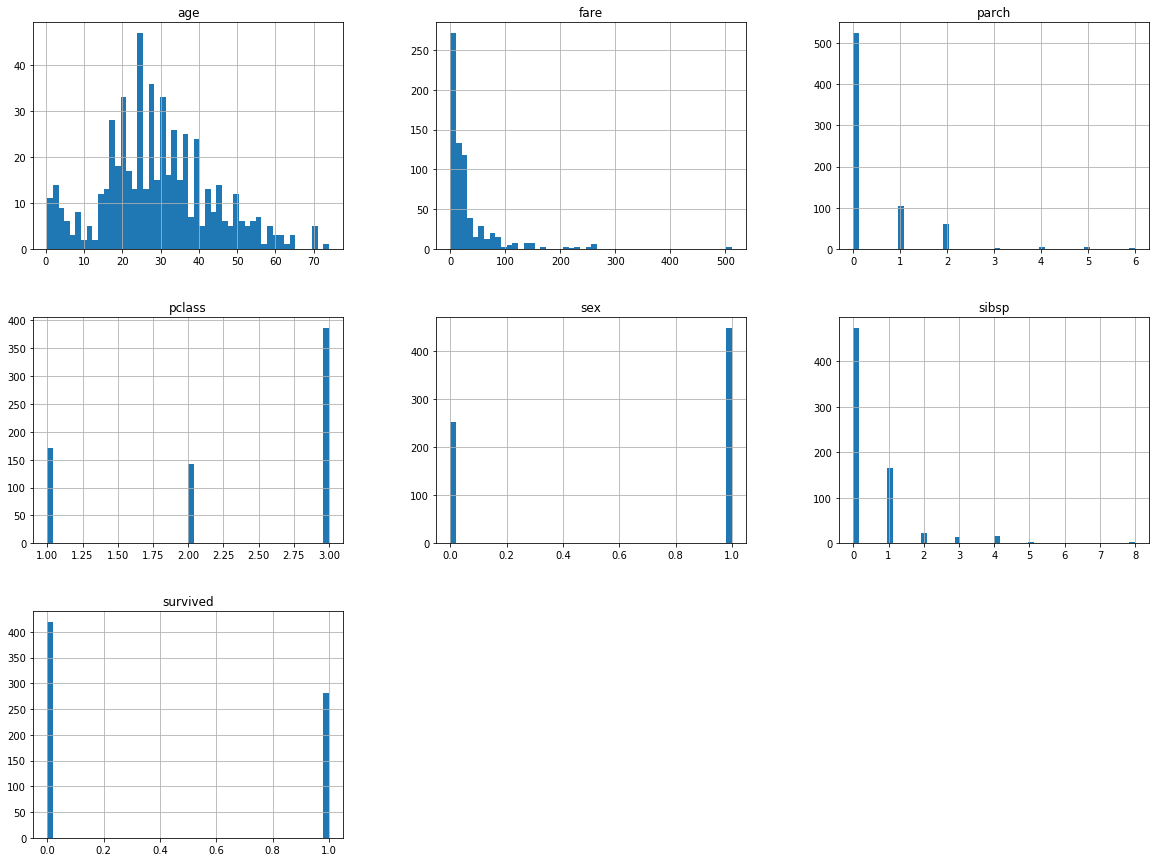

In [277]:
%matplotlib inline
import matplotlib.pyplot as plt

titanic.hist(bins=50, figsize=(20,15))
plt.show()

## 4. Prepare the Data for Machine Learning
We get a fresh copy of the training data.

In [278]:
titanic = strat_train_set.drop("survived", axis=1)
titanic_labels = strat_train_set["survived"]

This is from the book.

In [279]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [280]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer

num_attribs = ["pclass", "age", "sibsp", "parch", "fare"]
cat_attribs = ["sex"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_encoder', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [281]:
titanic_prepared = full_pipeline.fit_transform(titanic)

## 5. Select and Train a Model

In [282]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

sgd_clf = RandomForestClassifier(random_state=42)
sgd_clf.fit(titanic_prepared, titanic_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

Ad-hoc demo of predictions

In [283]:
some_data = titanic.iloc[:5]
some_labels = titanic_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:\t", list(sgd_clf.predict(some_data_prepared)))
print("Labels:\t\t", list(some_labels))

Predictions:	 [1, 0, 1, 1, 1]
Labels:		 [1, 0, 1, 1, 1]


In [284]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, titanic_prepared, titanic_labels, cv=3, scoring="accuracy")

array([ 0.81276596,  0.80425532,  0.79399142])

In [285]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

labels_pred = cross_val_predict(sgd_clf, titanic_prepared, titanic_labels, cv=3)
confusion_matrix(titanic_labels, labels_pred)

array([[361,  58],
       [ 80, 204]])

In [286]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(titanic_labels, labels_pred))
print(recall_score(titanic_labels, labels_pred))
print(f1_score(titanic_labels, labels_pred))

0.778625954198
0.718309859155
0.747252747253


In [287]:
from sklearn.metrics import precision_recall_curve

label_scores = cross_val_predict(sgd_clf, titanic_prepared, titanic_labels, 
                                 cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(titanic_labels, label_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

## 6. Fine-Tune Your Model

In [292]:
feature_importances = sgd_clf.feature_importances_
feature_importances

array([ 0.05615855,  0.25101946,  0.05017197,  0.04571022,  0.30506584,
        0.29187396])

In [293]:
attributes = num_attribs + cat_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.30506583758687145, 'fare'),
 (0.29187395660850102, 'sex'),
 (0.25101945798146819, 'age'),
 (0.056158554268220341, 'pclass'),
 (0.050171973200132128, 'sibsp'),
 (0.045710220354806923, 'parch')]